# Загрузка Pandas и очистка данных

In [2]:
from plotly.offline import init_notebook_mode, plot, iplot
import seaborn as sns
import warnings
import plotly.offline as pyo
import cufflinks as cf
import plotly.graph_objects as go
import plotly.express as px
import plotly
from matplotlib import style
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

import re

import datetime

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

style.use('ggplot')
%matplotlib inline


pyo.init_notebook_mode(connected=True)
cf.go_offline()

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
from collections import Counter

In [119]:
RANDOM_SEED = 25

In [120]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [61]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0
sample_submission = pd.read_csv('sample_submission.csv')
data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [62]:
# Напишем функцию, которая выведет всю статистическую инфу по переменной и строит графики
def analyse_numeric(datafr, column):
    '''Визуализирует распределение числовой переменной.
       Принимает параметрами DataFrame и строковое название столбца
       Печатает различные статистические показатели и строит гистограмму.'''
    count = datafr[column].count()
    mean = datafr[column].mean()
    std = datafr[column].std()
    median = datafr[column].median()
    perc25 = datafr[column].quantile(0.25)
    perc75 = datafr[column].quantile(0.75)
    IQR = perc75 - perc25
    range_min = datafr[column].min()
    range_max = datafr[column].max()
    margin = (range_max - range_min)/10
    range_start = range_min - margin
    range_stop = range_max + margin
    range_ = (range_start, range_stop)
    outliers = datafr[column].loc[(
        datafr[column] < perc25 - 1.5*IQR) | (datafr[column] > perc75 + 1.5*IQR)]

    print('Количество: {}, Среднее: {:.3f}, Стандартное отклонение: {:.3f}.'.format(
        count, mean, std))
    print('Минимум: {}, 25-й перцентиль: {}, Медиана: {}, 75-й перцентиль: {}, Максимум: {}, IQR: {}.'
          .format(range_min, perc25, median, perc75, range_max, IQR))
    print('Количество пропусков в столбце: ', pd.isnull(datafr[column]).sum())
    print('Границы выбросов: [{f}, {l}].'.format(
        f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR), 'Количество выбросов: ', len(outliers))

    datafr[column].loc[datafr[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                  .hist(bins=30, range=range_, label='В границах выбросов')
    outliers.hist(bins=30, range=range_, label='Выбросы')

    plt.legend()

In [63]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

In [64]:
data.Restaurant_id.nunique()

13094

In [65]:
# в переменной 9283 (23.2%) пропущенных значений
# сохраним эту информацию
data['NAN_Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('float64')

# заполним пропуски значением 'Other'
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")

# закодируем значения в переменной до их преобразования
le = LabelEncoder()
le.fit(data['Cuisine Style'])
data['code_Cuisine Style'] = le.transform(data['Cuisine Style'])

In [66]:
data['Cuisine Style'] = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'")

temp_list = data['Cuisine Style'].tolist()


def list_unrar(list_of_lists):
    result = []
    for lst in list_of_lists:
        result.extend(lst)
    return result


temp_counter = Counter(list_unrar(temp_list))

In [67]:
# сформируем список достаточно уникальных кухонь и сформируем на его основе новый признак
list_of_unique_Cuisine = [x[0] for x in temp_counter.most_common()[-16:]]
data['unique_Cuisine_Style'] = data['Cuisine Style'].apply(lambda x: 1 if len(
    set(x) & set(list_of_unique_Cuisine)) > 0 else 0).astype('float64')

In [68]:
for cuisine in temp_counter:
    data[cuisine] = data['Cuisine Style'].apply(
        lambda x: 1 if cuisine in x else 0).astype('float64')

# генерируем новый признак кол-во кухонь в ресторане
data['count_Cuisine_Style'] = data['Cuisine Style'].apply(
    lambda x: len(x)).astype('float64')

In [69]:
data['count_Cuisine_Style'].mean()

2.62532

In [70]:
data['count_Cuisine_Style'].describe()

count    50000.000000
mean         2.625320
std          1.824029
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: count_Cuisine_Style, dtype: float64

Количество: 50000, Среднее: 2.625, Стандартное отклонение: 1.824.
Минимум: 1.0, 25-й перцентиль: 1.0, Медиана: 2.0, 75-й перцентиль: 4.0, Максимум: 21.0, IQR: 3.0.
Количество пропусков в столбце:  0
Границы выбросов: [-3.5, 8.5]. Количество выбросов:  126


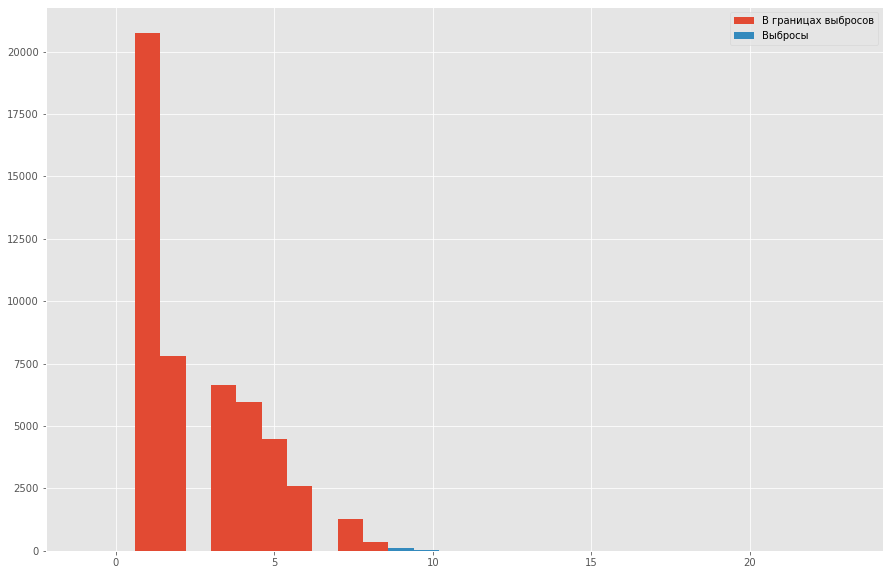

In [71]:
analyse_numeric(data, 'count_Cuisine_Style')

In [72]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample',
       ...
       'Central Asian', 'Polynesian', 'Caucasian', 'Uzbek', 'Salvadoran',
       'Xinjiang', 'Burmese', 'Fujian', 'Latvian', 'count_Cuisine_Style'],
      dtype='object', length=141)

In [73]:
data['Reviews'] = data['Reviews'].fillna('[[], []]')

In [74]:
data['Date_of_review'] = data['Reviews'].str.findall('\d+/\d+/\d+')
data['Len_date'] = data['Date_of_review'].apply(lambda x: len(x))
data[['Date_of_review', 'Reviews']].head()

,Date_of_review,Reviews
0,[],"[[], []]"
1,"[12/05/2017, 10/29/2017]","[['Very good reviews!', 'Fine dining in Hakani..."
2,"[12/28/2017, 12/06/2017]","[['Better than the Links', 'Ivy Black'], ['12/..."
3,"[12/06/2017, 11/22/2017]","[['Most exquisite', 'Delicious and authentic']..."
4,"[02/08/2018, 01/24/2018]","[['Always the best in bratislava', 'Very good ..."


In [75]:
data.Date_of_review.apply(lambda x: len(x)).value_counts()

2    36202
0     8114
1     5680
3        4
Name: Date_of_review, dtype: int64

In [76]:
# Рассмотрим отзывы с тремя датами:
print("значения Reviews с тремя датами :=")
temp_list = data[data['Len_date'] == 3].Reviews.to_list()
display(data[data['Len_date'] == 3].Reviews.to_list())
display([re.findall('\d+/\d+/\d+', x) for x in temp_list])

значения Reviews с тремя датами :=


["[['We visited 21/10/17', 'Best Kebab in London'], ['12/22/2017', '10/19/2017']]",
 "[['Good Museum Cafeteria', 'Lunch 30/5/2017'], ['04/13/2017', '05/30/2017']]",
 "[['The desserts arcade !', 'Visit today 3/1/2017'], ['06/02/2017', '01/03/2017']]",
 "[['lunch 29/9/2016', 'Unplanned Great Dinner'], ['09/30/2016', '08/25/2016']]"]

[['21/10/17', '12/22/2017', '10/19/2017'],
 ['30/5/2017', '04/13/2017', '05/30/2017'],
 ['3/1/2017', '06/02/2017', '01/03/2017'],
 ['29/9/2016', '09/30/2016', '08/25/2016']]

In [77]:
data['Len_date'].Date_of_review = data[data['Len_date']
                                       == 3].Date_of_review.apply(lambda x: x.pop(0))

In [78]:
# Заполним перерыв между отзывами (по двум отзывам) и отследим насколько давно был сделан последний отзыв:
def time_to_now(row):
    if row['Date_of_review'] == []:
        return None
    return pd.datetime.now() - pd.to_datetime(row['Date_of_review']).max()


def time_between_reviews(row):
    if row['Date_of_review'] == []:
        return None
    return pd.to_datetime(row['Date_of_review']).max() - pd.to_datetime(row['Date_of_review']).min()


data['Day_to_now'] = data.apply(time_to_now, axis=1).dt.days
data['Day_between_reviews'] = data[data['Len_date'] == 2].apply(
    time_between_reviews, axis=1).dt.days

Количество: 36202, Среднее: 142.556, Стандартное отклонение: 222.565.
Минимум: 0.0, 25-й перцентиль: 20.0, Медиана: 67.0, 75-й перцентиль: 173.0, Максимум: 3296.0, IQR: 153.0.
Количество пропусков в столбце:  13798
Границы выбросов: [-209.5, 402.5]. Количество выбросов:  2920


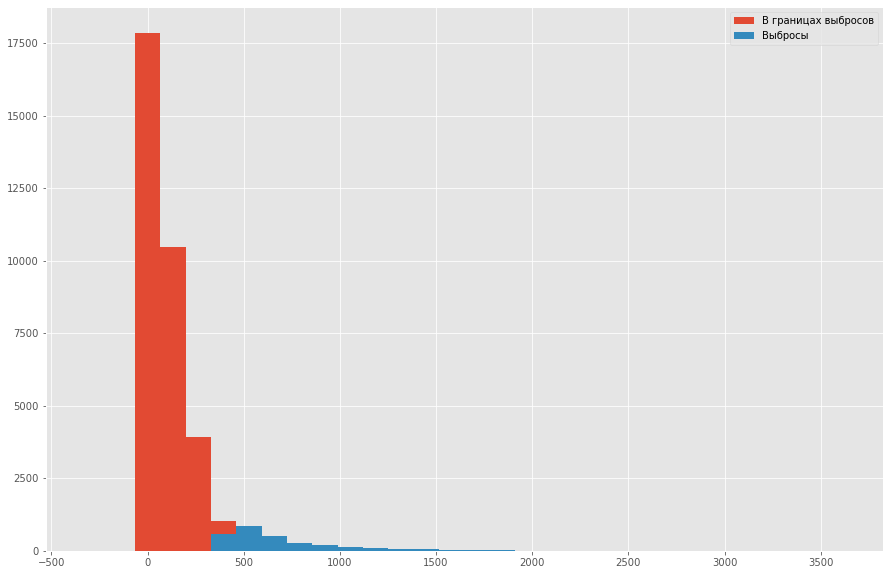

In [79]:
analyse_numeric(data, 'Day_between_reviews')

Количество: 41886, Среднее: 1419.045, Стандартное отклонение: 363.252.
Минимум: 1129.0, 25-й перцентиль: 1208.0, Медиана: 1282.0, 75-й перцентиль: 1466.0, Максимум: 6188.0, IQR: 258.0.
Количество пропусков в столбце:  8114
Границы выбросов: [821.0, 1853.0]. Количество выбросов:  4014


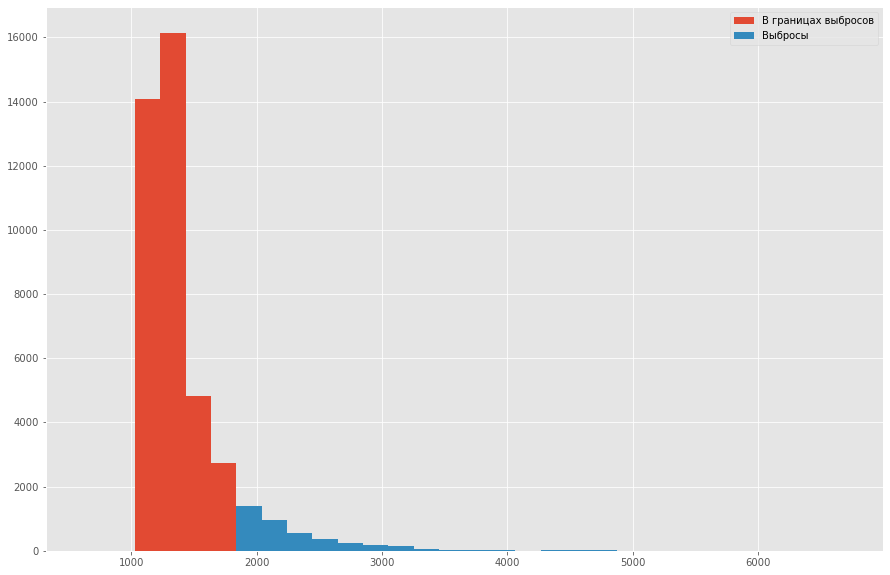

In [80]:
analyse_numeric(data, 'Day_to_now')

In [81]:
# Проверим количество пропусков в новых переменных
print('Пропусков в столбце с разницей между сегодняшним днём и последним отзывом: {}'.format(
    data['Day_to_now'].isna().sum()))
print('Пропусков в столбце с разницей между двумя отзывами: {}'.format(
    data['Day_between_reviews'].isna().sum()))

Пропусков в столбце с разницей между сегодняшним днём и последним отзывом: 8114
Пропусков в столбце с разницей между двумя отзывами: 13798


In [82]:
# Заполним пропуски нулями

data['Day_to_now'] = data['Day_to_now'].fillna(0)
data['Day_between_reviews'] = data['Day_between_reviews'].fillna(0)

In [83]:
# Создадим параметр Rev_year - год последнего отзыва.
# Для этого выделим из даты отзыва более свежий отзыв:
def last_review(row):
    if row == []:
        return None
    return pd.to_datetime(row).max()


data['Last_review'] = data['Date_of_review'].apply(last_review)

In [84]:
# Заполним пропуски минимальным значением:
data['Last_review'].min()

Timestamp('2004-04-21 00:00:00')

In [85]:
data['Last_review'] = data['Last_review'].apply(
    lambda x: '2004-04-21' if pd.isnull(x) else x)
data['Rev_year'] = data['Last_review'].dt.year

In [86]:
# Создадим параметр Rev_weekday - день недели последнего отзыва:
data['Rev_weekday'] = data['Last_review'].dt.dayofweek
data = data.drop(['Last_review'], axis=1)

In [87]:
# в переменной очень много пропусков 13886 (34.7%)
# сохраним информацию о пропусках чтобы не потерять
data['NaN_Price Range'] = pd.isna(data['Price Range']).astype('float64')

# заполним значения в переменной по словарю
dic_value_Price = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
data['Price_Range'] = data['Price Range'].map(
    lambda x: dic_value_Price.get(x, x))

# 18412 ресторанов это более 70% из заполненной информации имеют средний параметр цены
# поэтому заполняем пропуски двойкой (2)
data['Price_Range'] = data['Price_Range'].fillna(2)

In [88]:
data['Price_Range'].describe()

count    50000.000000
mean         1.879320
std          0.421189
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price_Range, dtype: float64

Количество: 50000, Среднее: 1.879, Стандартное отклонение: 0.421.
Минимум: 1.0, 25-й перцентиль: 2.0, Медиана: 2.0, 75-й перцентиль: 2.0, Максимум: 3.0, IQR: 0.0.
Количество пропусков в столбце:  0
Границы выбросов: [2.0, 2.0]. Количество выбросов:  9598


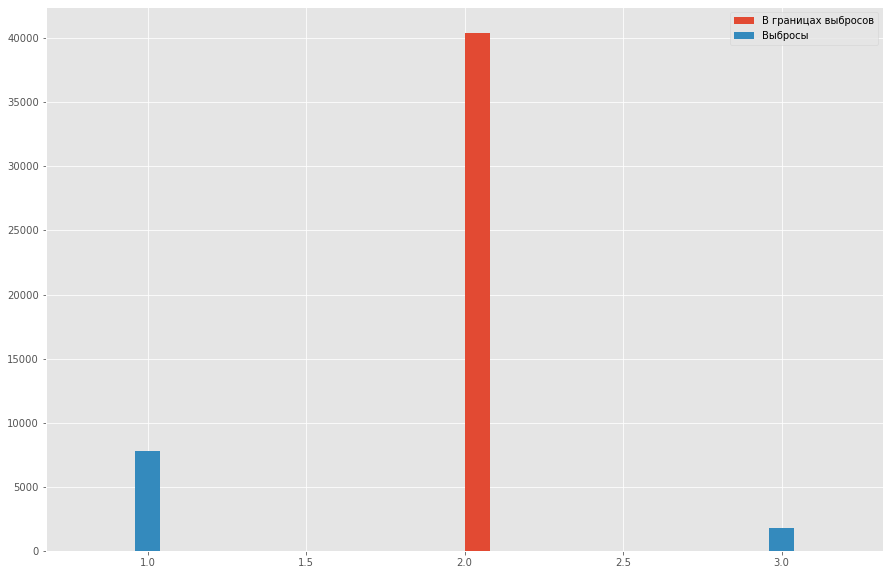

In [89]:
analyse_numeric(data, 'Price_Range')

In [90]:
# в переменной 2543 (6.4%) пропущенных значений
# сохраним эту информацию
data['NAN_Number of Reviews'] = pd.isna(
    data['Number of Reviews']).astype('float64')

# для удобства изменим название столбца
data.rename(columns={'Number of Reviews': 'Number_of_Reviews'}, inplace=True)
data['Number_of_Reviews'].fillna(0, inplace=True)

Количество: 50000, Среднее: 116.505, Стандартное отклонение: 286.173.
Минимум: 0.0, 25-й перцентиль: 7.0, Медиана: 28.0, 75-й перцентиль: 105.0, Максимум: 9660.0, IQR: 98.0.
Количество пропусков в столбце:  0
Границы выбросов: [-140.0, 252.0]. Количество выбросов:  5946


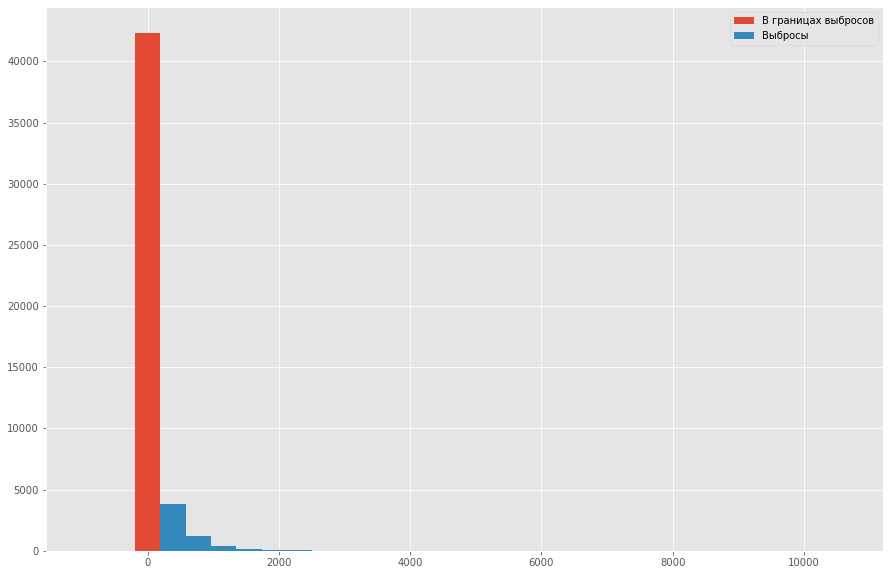

In [91]:
analyse_numeric(data, 'Number_of_Reviews')

In [92]:
# Рассмотрим расределение ранга ресторанов и количества отзывов в зависимости от количества кухонь:
data.pivot_table(values=['Ranking', 'Number_of_Reviews'],
                 index='count_Cuisine_Style',
                 aggfunc='mean').iplot(kind='bar', title='Ранг ресторанов и количество отзывов в зависимости от количества кухонь')

In [93]:
data.columns.values

array(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample',
       'Rating', 'NAN_Cuisine Style', 'code_Cuisine Style',
       'unique_Cuisine_Style', 'Bar', 'Pub', 'European', 'Scandinavian',
       'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options',
       'Italian', 'Mediterranean', 'Seafood', 'French', 'Cafe',
       'Fast Food', 'Portuguese', 'Other', 'Greek', 'Czech',
       'Eastern European', 'Central European', 'Pizza', 'British',
       'Spanish', 'Norwegian', 'African', 'Moroccan', 'Middle Eastern',
       'Halal', 'Indian', 'Thai', 'Dutch', 'Welsh', 'American',
       'Steakhouse', 'Soups', 'Scottish', 'Fusion', 'Street Food',
       'Hungarian', 'Asian', 'Wine Bar', 'Barbecue', 'Central American',
       'Peruvian', 'South American', 'Irish', 'Polish', 'Vietnamese',
       'Lebanese', 'Turkish', 'Healthy', 'Japanese', 'Sushi', 'Austrian',
       'Chinese', 'Danish', 'International

In [94]:
df_count = data.City.value_counts()

In [95]:
# Добавим в наш датасет количество ресторанов по городам
data['quantity'] = data['City'].apply(lambda x: df_count[x])

In [96]:
population_dict = {
    'London': 9304016,
    'Paris': 2140526,
    'Madrid': 3348536,
    'Barcelona': 1620343,
    'Berlin': 3748148,
    'Milan': 1404239,
    'Rome': 2856133,
    'Prague': 1324277,
    'Lisbon': 506654,
    'Vienna': 1911728,
    'Amsterdam': 873555,
    'Brussels': 1209000,
    'Hamburg': 1841179,
    'Munich': 1471508,
    'Lyon': 515695,
    'Stockholm': 974073,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 626508,
    'Athens': 664046,
    'Edinburgh': 524930,
    'Zurich': 415367,
    'Oporto': 237559,
    'Geneva': 201818,
    'Krakow': 779115,
    'Oslo': 693491,
    'Helsinki': 648042,
    'Bratislava': 432864,
    'Luxembourg': 613894,
    'Ljubljana': 292988
}

In [97]:
data['population'] = data['City'].map(population_dict)

In [98]:
data['population'] = data['population'] / 1000
data['quantity_density'] = data.quantity / data.population

In [99]:
data.drop(['City', 'Cuisine Style', 'Price Range',
           'Reviews', 'URL_TA', 'sample',
           'NAN_Cuisine Style',
           'unique_Cuisine_Style', 'Bar', 'Pub', 'European', 'Scandinavian',
           'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options',
           'Italian', 'Mediterranean', 'Seafood', 'French', 'Cafe',
           'Fast Food', 'Portuguese', 'Other', 'Greek', 'Czech',
           'Eastern European', 'Central European', 'Pizza', 'British',
           'Spanish', 'Norwegian', 'African', 'Moroccan', 'Middle Eastern',
           'Halal', 'Indian', 'Thai', 'Dutch', 'Welsh', 'American',
           'Steakhouse', 'Soups', 'Scottish', 'Fusion', 'Street Food',
           'Hungarian', 'Asian', 'Wine Bar', 'Barbecue', 'Central American',
           'Peruvian', 'South American', 'Irish', 'Polish', 'Vietnamese',
           'Lebanese', 'Turkish', 'Healthy', 'Japanese', 'Sushi', 'Austrian',
           'Chinese', 'Danish', 'International', 'Gastropub', 'Korean',
           'German', 'Contemporary', 'Arabic', 'Diner', 'Swiss', 'Swedish',
           'Persian', 'Australian', 'Grill', 'Mexican', 'Latin', 'Belgian',
           'Argentinean', 'Tunisian', 'Russian', 'Nepali', 'Bangladeshi',
           'Colombian', 'Sri Lankan', 'Pakistani', 'Brew Pub', 'Israeli',
           'Brazilian', 'Delicatessen', 'Kosher', 'Ethiopian', 'Taiwanese',
           'Indonesian', 'Malaysian', 'Venezuelan', 'Balti', 'Armenian',
           'Slovenian', 'Caribbean', 'Jamaican', 'Ecuadorean', 'Chilean',
           'Hawaiian', 'Minority Chinese', 'Croatian', 'Cambodian', 'Afghani',
           'Tibetan', 'Romanian', 'Southwestern', 'Mongolian',
           'Cajun & Creole', 'Singaporean', 'Filipino', 'Cuban',
           'Native American', 'Canadian', 'Egyptian', 'Azerbaijani',
           'Georgian', 'Yunnan', 'New Zealand', 'Ukrainian', 'Albanian',
           'Central Asian', 'Polynesian', 'Caucasian', 'Uzbek', 'Salvadoran',
           'Xinjiang', 'Burmese', 'Fujian', 'Latvian',
           'Date_of_review', 'NaN_Price Range',
           'NAN_Number of Reviews', 'population', 'code_Cuisine Style', 'Rev_weekday'], axis=1).corr().unstack().sort_values().drop_duplicates()

count_Cuisine_Style  Ranking               -0.322408
Ranking              Number_of_Reviews     -0.223198
Rev_year             Ranking               -0.141727
Ranking              Len_date              -0.140930
count_Cuisine_Style  Day_between_reviews   -0.120783
Rating               Ranking               -0.109897
Number_of_Reviews    Day_between_reviews   -0.087311
count_Cuisine_Style  quantity_density      -0.081961
Rev_year             Price_Range           -0.077542
quantity_density     Len_date              -0.074253
Price_Range          Len_date              -0.073869
quantity_density     Rev_year              -0.068927
Price_Range          Day_to_now            -0.056373
quantity_density     Day_to_now            -0.038935
Price_Range          Day_between_reviews   -0.035101
Ranking              Price_Range           -0.026334
Day_between_reviews  Rating                -0.025955
quantity             count_Cuisine_Style   -0.024105
                     Rating                -0.

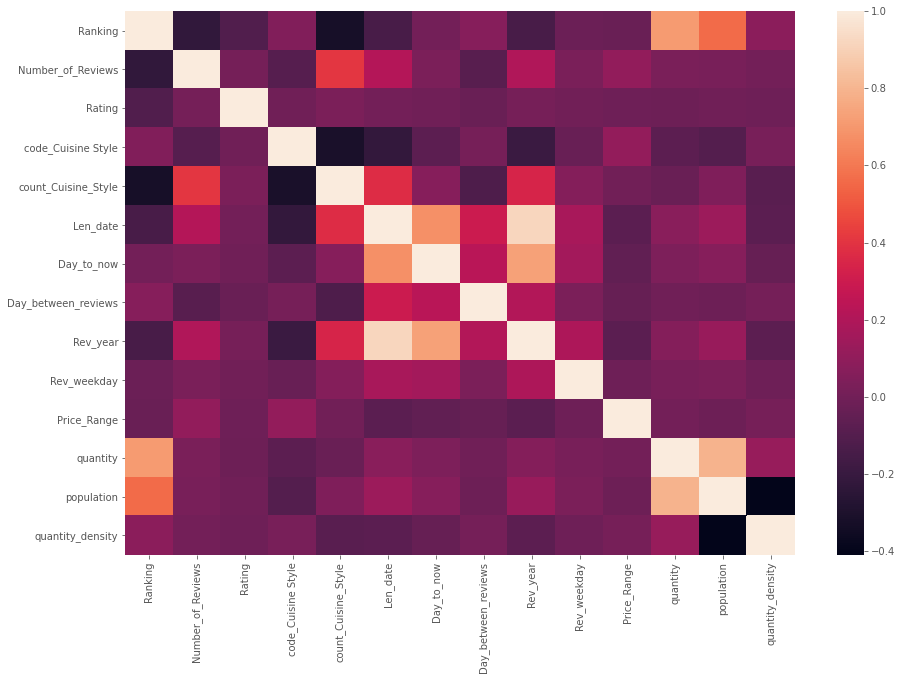

In [100]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(data.drop(['City', 'Cuisine Style', 'Price Range',
                       'Reviews', 'URL_TA', 'sample',
                       'NAN_Cuisine Style',
                       'unique_Cuisine_Style', 'Bar', 'Pub', 'European', 'Scandinavian',
                       'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options',
                       'Italian', 'Mediterranean', 'Seafood', 'French', 'Cafe',
                       'Fast Food', 'Portuguese', 'Other', 'Greek', 'Czech',
                       'Eastern European', 'Central European', 'Pizza', 'British',
                       'Spanish', 'Norwegian', 'African', 'Moroccan', 'Middle Eastern',
                       'Halal', 'Indian', 'Thai', 'Dutch', 'Welsh', 'American',
                       'Steakhouse', 'Soups', 'Scottish', 'Fusion', 'Street Food',
                       'Hungarian', 'Asian', 'Wine Bar', 'Barbecue', 'Central American',
                       'Peruvian', 'South American', 'Irish', 'Polish', 'Vietnamese',
                       'Lebanese', 'Turkish', 'Healthy', 'Japanese', 'Sushi', 'Austrian',
                       'Chinese', 'Danish', 'International', 'Gastropub', 'Korean',
                       'German', 'Contemporary', 'Arabic', 'Diner', 'Swiss', 'Swedish',
                       'Persian', 'Australian', 'Grill', 'Mexican', 'Latin', 'Belgian',
                       'Argentinean', 'Tunisian', 'Russian', 'Nepali', 'Bangladeshi',
                       'Colombian', 'Sri Lankan', 'Pakistani', 'Brew Pub', 'Israeli',
                       'Brazilian', 'Delicatessen', 'Kosher', 'Ethiopian', 'Taiwanese',
                       'Indonesian', 'Malaysian', 'Venezuelan', 'Balti', 'Armenian',
                       'Slovenian', 'Caribbean', 'Jamaican', 'Ecuadorean', 'Chilean',
                       'Hawaiian', 'Minority Chinese', 'Croatian', 'Cambodian', 'Afghani',
                       'Tibetan', 'Romanian', 'Southwestern', 'Mongolian',
                       'Cajun & Creole', 'Singaporean', 'Filipino', 'Cuban',
                       'Native American', 'Canadian', 'Egyptian', 'Azerbaijani',
                       'Georgian', 'Yunnan', 'New Zealand', 'Ukrainian', 'Albanian',
                       'Central Asian', 'Polynesian', 'Caucasian', 'Uzbek', 'Salvadoran',
                       'Xinjiang', 'Burmese', 'Fujian', 'Latvian',
                       'Date_of_review', 'NaN_Price Range',
                       'NAN_Number of Reviews'], axis=1).corr(),)

In [101]:
# Добавим дамми-переменные по городам
data = pd.concat([data, pd.get_dummies(data.City, prefix='City')], axis=1)
data.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
# Теперь нужно соотнести столицы по странам
countries_dict = {'Amsterdam': 'Netherlands',
                  'Athens': 'Greece',
                  'Barcelona': 'Spain',
                  'Berlin': 'Germany',
                  'Bratislava': 'Slovakia',
                  'Brussels': 'Belgium',
                  'Budapest': 'Hungary',
                  'Copenhagen': 'Denmark',
                  'Dublin': 'Ireland',
                  'Edinburgh': 'UK',
                  'Geneva': 'Switzerland',
                  'Hamburg': 'Germany',
                  'Helsinki': 'Finland',
                  'Krakow': 'Poland',
                  'Lisbon': 'Portugal',
                  'Ljubljana': 'Slovenia',
                  'London': 'UK',
                  'Luxembourg': 'Luxembourg',
                  'Lyon': 'France',
                  'Madrid': 'Spain',
                  'Milan': 'Italy',
                  'Munich': 'Germany',
                  'Oporto': 'Portugal',
                  'Oslo': 'Norway',
                  'Paris': 'France',
                  'Prague': 'Czechia',
                  'Rome': 'Italy',
                  'Stockholm': 'Sweden',
                  'Vienna': 'Austria',
                  'Warsaw': 'Poland',
                  'Zurich': 'Switzerland'}

data['country'] = data.apply(lambda row: countries_dict[row['City']], axis=1)

In [103]:
# Добавим данные по ВВП стране - это непосредственно влияет на количество посетителей и на качество ресторанов
dict_Economies = {'UK': 45741, 'France': 45893, 'Spain': 40172,
                  'Germany': 52386, 'Italy': 39676, 'Czech_c': 37340,
                  'Portugal': 32412, 'Austria': 52172, 'Holland': 56489,
                  'Belgium': 48327, 'Sweden': 53652, 'Romania': 26448,
                  'Poland': 32005, 'Ireland': 79617, 'Denmark': 52279,
                  'Greece': 29072, 'Scotland': 45741, 'Switzerland': 65010,
                  'Norway': 74357, 'Finland': 46596, 'Slovakia': 35136,
                  'Luxembourg': 106372, 'Slovenia': 36741, 'Hungary': 14225,
                  'Czechia': 20368, 'Netherlands': 48223}
data['Economy'] = data.apply(
    lambda row: dict_Economies[row['country']], axis=1)

In [104]:
# Добавим столбец Rest_density - сколько ресторанов приходится на человека в городе (плотность ресторанов):
data['quantity_density'] = data['quantity'] / data['population']

In [105]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis=1, inplace=True)

In [106]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [107]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [108]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [109]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [110]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [111]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2081645


In [112]:
###готовим submission
test_data.sample(10)


,Ranking,Number_of_Reviews,Rating,NAN_Cuisine Style,code_Cuisine Style,unique_Cuisine_Style,Bar,Pub,European,Scandinavian,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Economy
5339,524.0,3.0,0.0,0.0,2053,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,106372
2792,5921.0,3.0,0.0,1.0,9173,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,40172
2064,1512.0,0.0,0.0,0.0,2513,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,52386
2606,2079.0,3.0,0.0,0.0,6201,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,32412
5108,836.0,23.0,0.0,0.0,10404,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,52386
2699,404.0,91.0,0.0,0.0,7113,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,48327
994,1580.0,2.0,0.0,0.0,322,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,32005
7133,4184.0,32.0,0.0,0.0,9385,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,39676
9505,1324.0,4.0,0.0,1.0,9173,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,53652
1922,3311.0,181.0,0.0,0.0,4750,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,45893


In [113]:
test_data = test_data.drop(['Rating'], axis=1)


In [114]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [116]:
predict_submission = regr.predict(test_data)


In [117]:
predict_submission

array([3.03 , 4.14 , 4.33 , ..., 3.02 , 4.42 , 4.425])

In [118]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.030
1,id_1,4.140
2,id_2,4.330
3,id_3,4.380
4,id_4,4.390
5,id_5,4.410
6,id_6,1.190
7,id_7,2.485
8,id_8,4.045
9,id_9,4.555
